

> **Deliverable 2: Flight Difficulty Score Development**



In [3]:

#  Deliverable 2: Flight Difficulty Score Development
#  Team: Maverick
# Step 1 — Import Libraries


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print(" Libraries imported successfully.")


 Libraries imported successfully.


**Step 2 — Load All CSV Files**

In [9]:
flight_data = pd.read_csv('Flight Level Data.csv')
bags_data = pd.read_csv('BagLevelData.csv')
pnr_flight_data = pd.read_csv('PNRFlightLevelData.csv')
pnr_remarks_data = pd.read_csv('PNR Remark Level Data.csv')
airport_data = pd.read_csv('Airports Data.csv')

print(" All CSV files loaded successfully.")
print(f"Flights: {flight_data.shape}, Bags: {bags_data.shape}, PNRs: {pnr_flight_data.shape}")




 All CSV files loaded successfully.
Flights: (8099, 15), Bags: (687245, 8), PNRs: (687878, 12)


**Data Merging and Preprocessing**

In [10]:
flight_data.columns = flight_data.columns.str.strip().str.lower()
for c in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local',
          'actual_departure_datetime_local', 'actual_arrival_datetime_local',
          'scheduled_departure_date_local']:
    flight_data[c] = pd.to_datetime(flight_data[c], errors='coerce')

flight_data.drop_duplicates(subset=['company_id', 'flight_number', 'scheduled_departure_date_local'], inplace=True)
flight_data.dropna(subset=['actual_departure_datetime_local'], inplace=True)

pnr_flight_data.columns = pnr_flight_data.columns.str.strip().str.lower()
pnr_flight_data['scheduled_departure_date_local'] = pd.to_datetime(pnr_flight_data['scheduled_departure_date_local'], errors='coerce')

bags_data.columns = bags_data.columns.str.strip().str.lower()
bags_data['scheduled_departure_date_local'] = pd.to_datetime(bags_data['scheduled_departure_date_local'], errors='coerce')

pnr_remarks_data.columns = pnr_remarks_data.columns.str.strip().str.lower()

print(" Data cleaning complete for all input datasets.")


 Data cleaning complete for all input datasets.


**Aggregate Passenger, Bag, and SSR Data**

In [11]:
# Passenger aggregation
unique_pnr = pnr_flight_data.drop_duplicates(subset=['record_locator', 'flight_number', 'scheduled_departure_date_local'])
pax_summary = unique_pnr.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).agg(
    total_pax=('total_pax', 'sum'),
    child_pax=('is_child', lambda x: (x == 'Y').sum()),
    lap_child=('lap_child_count', 'sum')
).reset_index()

# Bag aggregation
bag_summary = bags_data.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: x.isin(['Transfer', 'Hot']).sum()),
    hot_bags=('bag_type', lambda x: (x == 'Hot').sum())
).reset_index()

# SSR aggregation
pnr_ref = pnr_flight_data[['record_locator', 'company_id', 'flight_number', 'scheduled_departure_date_local']].drop_duplicates()
merged_ssr = pd.merge(pnr_remarks_data.drop(columns=['flight_number', 'pnr_creation_date']), pnr_ref, on='record_locator', how='left')
ssr_summary = merged_ssr.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).size().reset_index(name='ssr_count')

print(" Passenger, baggage, and SSR aggregation complete.")


 Passenger, baggage, and SSR aggregation complete.


**Merge into Master DataFrame**

In [12]:
merged_df = pd.merge(flight_data, pax_summary, on=['company_id','flight_number','scheduled_departure_date_local'], how='left')
merged_df = pd.merge(merged_df, bag_summary, on=['company_id','flight_number','scheduled_departure_date_local'], how='left')
merged_df = pd.merge(merged_df, ssr_summary, on=['company_id','flight_number','scheduled_departure_date_local'], how='left')

for col in ['total_pax','child_pax','lap_child','total_bags','transfer_bags','hot_bags','ssr_count']:
    merged_df[col] = merged_df[col].fillna(0)

print(f" Master dataset prepared successfully — shape: {merged_df.shape}")


 Master dataset prepared successfully — shape: (8063, 22)


**Feature Engineering**

In [18]:

# FEATURE ENGINEERING — MAVERICK TEAM


import pandas as pd
import numpy as np

print(" Initiating Feature Engineering...")

#  Data Cleaning before Feature Creation

# Standardize column names
for df in [flight_data, bags_data, pnr_flight_data, pnr_remarks_data, airport_data]:
    df.columns = df.columns.str.lower().str.strip()

# Convert date columns in flight data
for col in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local',
            'actual_departure_datetime_local', 'actual_arrival_datetime_local',
            'scheduled_departure_date_local']:
    if col in flight_data.columns:
        flight_data[col] = pd.to_datetime(flight_data[col], errors='coerce')

#  Aggregations from Secondary Tables 

#  Passenger-Level Aggregation
pax_agg = (
    pnr_flight_data.drop_duplicates(subset=['record_locator', 'flight_number', 'scheduled_departure_date_local'])
    .groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])
    .agg(
        total_pax=('total_pax', 'sum'),
        child_pax_count=('is_child', lambda x: (x == 'Y').sum()),
        lap_child_count=('lap_child_count', 'sum')
    ).reset_index()
)

#  Bag-Level Aggregation
bag_agg = (
    bags_data.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])
    .agg(
        total_bags=('bag_tag_unique_number', 'count'),
        transfer_bags=('bag_type', lambda x: x.isin(['Transfer', 'Hot']).sum()),
        hot_transfer_bags=('bag_type', lambda x: (x == 'Hot').sum())
    ).reset_index()
)

#  SSR (Special Service Requests)
pnr_with_date = pnr_flight_data[['record_locator', 'company_id', 'flight_number', 'scheduled_departure_date_local']].drop_duplicates()
remarks_merge = pd.merge(
    pnr_remarks_data[['record_locator', 'special_service_request']],
    pnr_with_date,
    on='record_locator',
    how='left'
)
ssr_agg = remarks_merge.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local']).size().reset_index(name='ssr_count')

#  Merge All Data into a Master Frame 
master_df = (
    flight_data
    .merge(pax_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(bag_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
    .merge(ssr_agg, on=['company_id', 'flight_number', 'scheduled_departure_date_local'], how='left')
)

# Fill NaNs in numeric fields
for col in ['total_pax', 'child_pax_count', 'lap_child_count', 'total_bags',
            'transfer_bags', 'hot_transfer_bags', 'ssr_count']:
    master_df[col] = master_df[col].fillna(0)

print(f" Master dataframe ready with {master_df.shape[0]} rows and {master_df.shape[1]} columns.")

#  Begin Feature Engineering 

# (a) Ground Pressure
master_df['feat_ground_pressure'] = master_df['minimum_turn_minutes'] / master_df['scheduled_ground_time_minutes']

# (b) Load Factor
master_df['feat_load_factor'] = master_df['total_pax'] / master_df['total_seats']

# (c) Child Ratio
master_df['feat_child_ratio'] = (master_df['child_pax_count'] + master_df['lap_child_count']) / master_df['total_pax']

# (d) Bags per Pax
master_df['feat_bags_per_pax'] = master_df['total_bags'] / master_df['total_pax']

# (e) Transfer Bag Ratio
master_df['feat_transfer_ratio'] = master_df['transfer_bags'] / master_df['total_bags']

# (f) Aircraft Type (Widebody)
wide_bodies = ['B767', 'B777', 'B787', 'A330', 'A340', 'A350', 'A380']
master_df['feat_is_widebody'] = master_df['fleet_type'].apply(lambda x: 1 if any(w in str(x) for w in wide_bodies) else 0)

# (g) Flight Duration (Haul Category)
master_df['flight_duration_hr'] = (
    master_df['scheduled_arrival_datetime_local'] - master_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 3600

master_df['feat_haul_type'] = pd.cut(
    master_df['flight_duration_hr'],
    bins=[-1, 3, 6, 24],
    labels=[0, 1, 2]
)
master_df['feat_haul_type'] = pd.to_numeric(master_df['feat_haul_type'], errors='coerce').fillna(0).astype(int)

# (h) SSR & Hot Bag Pressure
master_df.rename(columns={'ssr_count': 'feat_ssr_count', 'hot_transfer_bags': 'feat_hot_bags'}, inplace=True)

# (i) Departure Hour
master_df['feat_depart_hour'] = master_df['scheduled_departure_datetime_local'].dt.hour

# (j) International Flights
airport_data.columns = airport_data.columns.str.lower().str.strip()
master_df = pd.merge(
    master_df,
    airport_data[['airport_iata_code', 'iso_country_code']],
    left_on='scheduled_arrival_station_code',
    right_on='airport_iata_code',
    how='left'
)
master_df['feat_is_international'] = (master_df['iso_country_code'] != 'US').astype(int)

#  Data Cleanup 
features_to_clean = [
    'feat_ground_pressure', 'feat_load_factor', 'feat_child_ratio',
    'feat_bags_per_pax', 'feat_transfer_ratio'
]
master_df[features_to_clean] = master_df[features_to_clean].replace([np.inf, -np.inf], np.nan).fillna(0)

print(" Feature Engineering Completed Successfully!")





 Initiating Feature Engineering...
 Master dataframe ready with 8063 rows and 22 columns.
 Feature Engineering Completed Successfully!


**FLIGHT DIFFICULTY SCORING AND CLASSIFICATION**

In [20]:

#  STEP 7: FLIGHT DIFFICULTY SCORING AND CLASSIFICATION


from sklearn.preprocessing import MinMaxScaler

print(" Initiating Flight Difficulty Scoring...")


#  Define Key Feature Set & Associated Weights

feature_cols = [
    'feat_ground_pressure', 'feat_transfer_ratio', 'feat_ssr_count',
    'feat_load_factor', 'feat_is_widebody', 'feat_bags_per_pax',
    'feat_haul_type', 'feat_is_international', 'feat_hot_bags', 'feat_child_ratio'
]

# Weighted based on operational importance (higher = more impact)
feature_weights = {
    'feat_ground_pressure': 0.25,  # tight ground turns are most stressful
    'feat_transfer_ratio': 0.20,
    'feat_ssr_count': 0.15,
    'feat_load_factor': 0.10,
    'feat_is_widebody': 0.07,
    'feat_bags_per_pax': 0.05,
    'feat_haul_type': 0.05,
    'feat_is_international': 0.05,
    'feat_hot_bags': 0.05,
    'feat_child_ratio': 0.03
}


#  Daily-Level Normalization & Score Calculation

all_days_results = []

for date, daily_df in master_df.groupby(master_df['scheduled_departure_date_local']):
    daily = daily_df.copy()

    # Normalize each feature between 0 and 1
    for col in feature_cols:
        if daily[col].max() == daily[col].min():
            daily[f'{col}_norm'] = 0
        else:
            scaler = MinMaxScaler()
            daily[f'{col}_norm'] = scaler.fit_transform(daily[[col]])

    # Compute difficulty score using weighted sum
    daily['difficulty_score'] = 0
    for col, weight in feature_weights.items():
        daily['difficulty_score'] += daily[f'{col}_norm'] * weight

    all_days_results.append(daily)

# Combine all daily scores
scored_df = pd.concat(all_days_results, ignore_index=True)


#  Ranking & Classification (within each day)

# Normalize difficulty scores to range 1–100
scored_df['difficulty_score'] = (
    MinMaxScaler(feature_range=(1, 100)).fit_transform(scored_df[['difficulty_score']])
)

# Rank flights within each day
scored_df['daily_rank'] = scored_df.groupby(scored_df['scheduled_departure_date_local'])['difficulty_score'] \
                                   .rank(method='first', ascending=False)

# Classification based on rank distribution
def classify_flight(rank, total):
    if rank <= total * 0.2:
        return 'Difficult'
    elif rank <= total * 0.7:
        return 'Medium'
    else:
        return 'Easy'

# Apply classification
total_daily_flights = scored_df.groupby(scored_df['scheduled_departure_date_local'])['daily_rank'].transform('max')
scored_df['difficulty_class'] = scored_df.apply(
    lambda x: classify_flight(x['daily_rank'], total_daily_flights[x.name]), axis=1
)

print(" Flight Difficulty Score Calculated and Ranked Successfully!")


#  Quick Summary Insight

summary = scored_df['difficulty_class'].value_counts(normalize=True) * 100
print("\nDifficulty Class Distribution (%):")
print(summary.round(2))



 Initiating Flight Difficulty Scoring...
 Flight Difficulty Score Calculated and Ranked Successfully!

Difficulty Class Distribution (%):
difficulty_class
Medium       49.99
Easy         30.06
Difficult    19.94
Name: proportion, dtype: float64


**VISUALIZATION(DIFFICULT,EASY,MEDIUM)**

/tmp/ipython-input-3651123657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=scored_df, x='difficulty_class', palette=['#ff6b6b', '#feca57', '#1dd1a1'])


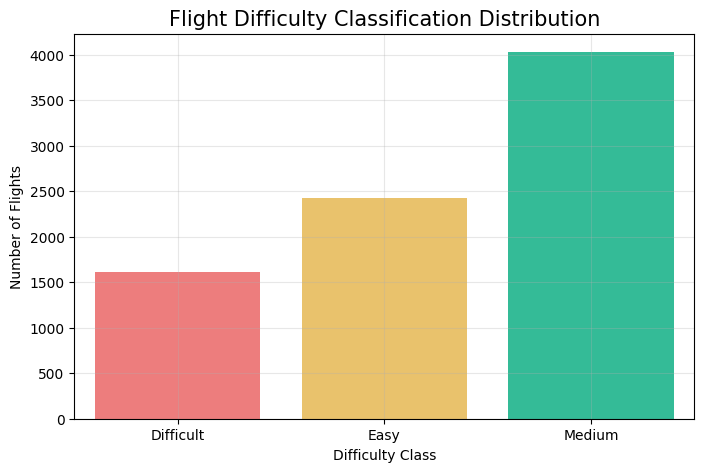

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=scored_df, x='difficulty_class', palette=['#ff6b6b', '#feca57', '#1dd1a1'])
plt.title("Flight Difficulty Classification Distribution", fontsize=15)
plt.xlabel("Difficulty Class")
plt.ylabel("Number of Flights")
plt.grid(alpha=0.3)
plt.show()


**FINAL OUTPUT — MAVERICK TEAM**

In [22]:

# STEP 8: FINAL OUTPUT — MAVERICK TEAM


print(" Preparing Final Submission File...")

#  Team Name
team_name = "Maverick"

#  Columns to include in final output (as per submission rules)
flight_details = [
    'company_id', 'flight_number', 'scheduled_departure_date_local',
    'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'fleet_type'
]

feature_cols = [
    'feat_ground_pressure', 'feat_transfer_ratio', 'feat_ssr_count',
    'feat_load_factor', 'feat_is_widebody', 'feat_bags_per_pax',
    'feat_haul_type', 'feat_is_international', 'feat_hot_bags', 'feat_child_ratio'
]

score_cols = ['difficulty_score', 'daily_rank', 'difficulty_class']

# Combine selected columns
final_output = scored_df[flight_details + feature_cols + score_cols]

#  Optional sanity check
print(f" Final dataset ready with {final_output.shape[0]} rows and {final_output.shape[1]} columns.")

#  Export to CSV
output_filename = f"test_{team_name}.csv"
final_output.to_csv(output_filename, index=False)

print("\n--------------------------------------------------")
print(f" SUCCESS: Submission file generated successfully!")
print(f" Filename: {output_filename}")


#  Show first few rows as preview
print(" Sample Preview:")
print(final_output.head(10))


 Preparing Final Submission File...
 Final dataset ready with 8063 rows and 19 columns.

--------------------------------------------------
SUCCESS: Submission file generated successfully!
 Filename: test_Maverick.csv
--------------------------------------------------

 Sample Preview:
  company_id  flight_number scheduled_departure_date_local  \
0         OO           5564                     2025-08-01   
1         UA           1899                     2025-08-01   
2         UA           2189                     2025-08-01   
3         G7           4590                     2025-08-01   
4         UA            224                     2025-08-01   
5         UA            763                     2025-08-01   
6         OO           5521                     2025-08-01   
7         OO           5790                     2025-08-01   
8         G7           4491                     2025-08-01   
9         OO           5140                     2025-08-01   

  scheduled_departure_station_

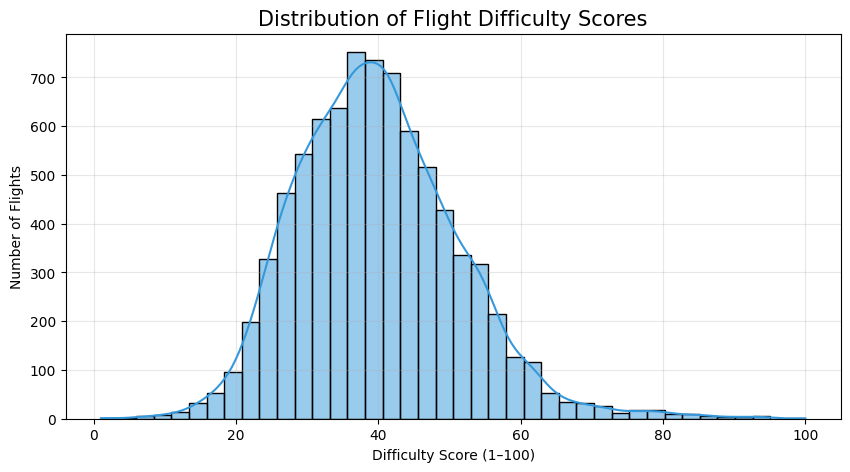

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(data=final_output, x='difficulty_score', bins=40, kde=True, color='#3498db')
plt.title("Distribution of Flight Difficulty Scores", fontsize=15)
plt.xlabel("Difficulty Score (1–100)")
plt.ylabel("Number of Flights")
plt.grid(alpha=0.3)
plt.show()


In [24]:
from google.colab import files

# Download the final submission file
files.download("test_Maverick.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>